# Bayes Nets
** A Julia package for Bayesian Networks **

A Bayesian Network (BN) represents a probability distribution over a set of variables, $P(x_1, x_2, \ldots, x_n)$. They leverage variable relations in order to efficiently decompose the joint distribution into smaller conditional probability distributions.

A BN is defined by a directed acyclic graph and a set of conditional probability distributions. Each node in the graph corresponds to a variable $x_i$ and is associated with a conditional probability distribution $P(x_i \mid \text{parents}(x_i))$.

## Installation

In [ ]:
Pkg.add("BayesNets");

Visualization of network structure is provided by the TikzGraphs package. Installation requirements (e.g., PGF/Tikz and pdf2svg) are provided [here](http://nbviewer.ipython.org/github/sisl/TikzGraphs.jl/blob/master/doc/TikzGraphs.ipynb).

## Use

In [1]:
srand(0) # seed the random number generator to 0, for a reproducible demonstration
using BayesNets

## Representation

Bayesian Networks are represented with the `BayesNet` type. This type contains the directed acyclic graph (a LightTables.DiGraph) and a list of conditional probability distributions (a list of CPDs)

Here we construct the BayesNet $a \rightarrow b$, with Gaussians $a$ and $b$:

$$
a = \mathcal{N}(0,1) \qquad b = \mathcal{N}(2a +3,1)
$$

In [2]:
bn = BayesNet()
push!(bn, StaticCPD(:a, Normal(1.0)))
push!(bn, LinearGaussianCPD(:b, [:a], [2.0], 3.0, 1.0))

## Conditional Probability Distributions

Conditional Probablity Distributions, $P(x_i \mid \text{parents}(x_i))$, are defined in BayesNets.CPDs. Each CPD knows its own name, the names of its parents, and is associated with a distribution from Distributions.jl.

| `CPDForm`                      | Description |
| ------------------------------ | ----------- |
| `StaticCPD`                    | Any `Distributions.distribution`; indepedent of any parents |
| `FunctionalCPD`                | Allows for a quick-and-dirty CPD with a custom eval function |
| `CategoricalCPD`               | Categorical distribution, assumes integer parents in $1:N$ |
| `LinearGaussianCPD`            | Linear Gaussian, assumes target and parents are numeric |
| `ConditionalLinearGaussianCPD` | A linear Gaussian for each discrete parent instantiation|

Each CPD can be learned from data using `fit`.

Here we learn the same network as above.

In [3]:
a = randn(100)
b = randn(100) .+ 2*a .+ 3

data = DataFrame(a=a, b=b)
cpdA = fit(StaticCPD{Normal}, data, :a)
cpdB = fit(LinearGaussianCPD, data, :b, [:a])

bn2 = BayesNet([cpdA, cpdB])

Each `CPD` implements four functions:

* `name(cpd)` - obtain the name of the variable target variable
* `parents(cpd)` - obtain the list of parents
* `nparams(cpd` - obtain the number of free parameters in the CPD
* `Base.call(cpd, assignment)` - allows calling `cpd()` to obtain the conditional distribution
* `Distributions.fit(Type{CPD}, data, target, parents)`

In [4]:
cpdB(:a=>0.5) # Base.call(cpd)

Distributions.Normal{Float64}(μ=3.7835395874388134, σ=2.236109637835203)

Several functions conveniently condition and then produce their return values:

In [5]:
rand(cpdB, :a=>0.5) # condition and then sample
pdf(cpdB, :a=>1.0, :b=>3.0) # condition and then compute pdf(distribution, 3)
logpdf(cpdB, :a=>1.0, :b=>3.0) # condition and then compute logpdf(distribution, 3);

The NamedCategorical distribution allows for String or Symbol return values.
The FunctionalCPD allows for crafting quick and simple CPDs:

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.4/BayesNets.ji for module BayesNets.


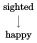

In [1]:
bn2 = BayesNet()
push!(bn2, StaticCPD(:sighted, NamedCategorical([:bird, :plane, :superman], [0.40, 0.55, 0.05])))
push!(bn2, FunctionalCPD{Bernoulli}(:happy, [:sighted], a->Bernoulli(a == :superman ? 0.95 : 0.2)))

## Likelihood 

A Bayesian Network represents a joint probability distribution, $P(x_1, x_2, \ldots, x_n)$. 
Assignments are represented as dictionaries mapping variable names (Symbols) to variable values.
We can evaluate probabilities as we would with Distributions.jl, only we use exclamation points as we modify the internal state when we condition:

In [7]:
pdf(bn, :a=>0.5, :b=>2.0) # evaluate the probability density

0.01900834726778591

We can also evaluate the likelihood of a dataset:

In [8]:
data = DataFrame(a=[0.5,1.0,2.0], b=[4.0,5.0,7.0])
pdf(bn, data)    #  0.00215
logpdf(bn, data) # -6.1386;

Or the likelihood for a particular cpd:

In [9]:
pdf(cpdB, data)    #  0.006
logpdf(cpdB, data) # -5.201

-5.200981176187056

## Sampling

Assignments can be sampled from a `BayesNet`.

In [10]:
rand(bn)

Dict{Symbol,Any} with 2 entries:
  :a => 1.0646767886110282
  :b => 6.0369902749018225

In [11]:
rand(bn, 5)

,a,b
1,0.7623039965961161,3.4917223005147227
2,-0.8005501733900879,0.23443764725795835
3,2.2115810954933637,7.515865521050183
4,-0.27359849027000194,3.7133964333979224
5,-0.42515634692622406,2.4710294668620785


Samples can be drawn that are consistent with a provided assignment:

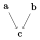

In [12]:
bn = BayesNet()
push!(bn, StaticCPD(:a, Categorical([0.3,0.7])))
push!(bn, StaticCPD(:b, Categorical([0.6,0.4])))
push!(bn, CategoricalCPD{Bernoulli}(:c, [:a, :b], [2,2], [Bernoulli(0.1), Bernoulli(0.2), Bernoulli(1.0), Bernoulli(0.4)]))

In [13]:
rand(bn, 5, Assignment(:c=>1))

,a,b,c
1,2,2,1
2,2,1,1
3,2,1,1
4,2,1,1
5,2,2,1


One can also use weighted sampling:

In [14]:
rand_table_weighted(bn; nsamples=5, consistent_with=Assignment(:c=>1))

,a,b,c,p
1,1,1,1,0.09090909090909091
2,2,1,1,0.18181818181818182
3,2,1,1,0.18181818181818182
4,2,2,1,0.36363636363636365
5,2,1,1,0.18181818181818182


## Parameter Learning

BayesNets.jl supports parameter learning for an entire graph.

In [15]:
# specify each node's CPD type individually
fit(BayesNet, data, (:a=>:b), [StaticCPD{Normal}, LinearGaussianCPD])

In [16]:
# specify a single CPD type for all nodes
fit(BayesNet, data, (:a=>:b), LinearGaussianCPD)

Fitting can be done for specific BayesNets types as well:

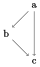

In [17]:
data = DataFrame(c=[1,1,1,1,2,2,2,2,3,3,3,3], 
                 b=[1,1,1,2,2,2,2,1,1,2,1,1],
                 a=[1,1,1,2,1,1,2,1,1,2,1,1])

fit(DiscreteBayesNet, data, (:a=>:b, :a=>:c, :b=>:c))

## Structure Learning

Structure learning can be done as well.

In [18]:
using Discretizers
using RDatasets
iris = dataset("datasets", "iris")
names(iris)
data = DataFrame(
    SepalLength = iris[:SepalLength],
    SepalWidth = iris[:SepalWidth],
    PetalLength = iris[:PetalLength],
    PetalWidth = iris[:PetalWidth],
    Species = encode(CategoricalDiscretizer(iris[:Species]), iris[:Species]),
)
data[1:3,:] # only plot a subset...

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
1,5.1,3.5,1.4,0.2,1
2,4.9,3.0,1.4,0.2,1
3,4.7,3.2,1.3,0.2,1


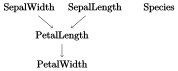

In [19]:
typealias CLG ConditionalLinearGaussianCPD
params = K2GraphSearch([:Species, :SepalLength, :SepalWidth, :PetalLength, :PetalWidth], 
                       [StaticCPD{Categorical}, CLG, CLG, CLG, CLG],
                       max_n_parents=2)
bn = fit(BayesNet, data, params)
bn

A `ScoringFunction` allows for extracting a scoring metric for a CPD given data.
The negative BIC score is implemented in NegativeBayesianInformationCriterion.

A `GraphSearchStrategy` defines a structure learning algorithm.
The K2 algorithm is defined through `K2GraphSearch` and `GreedyHillClimbing` is implemented for discrete Bayesian networks and the Bayesian score:

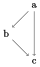

In [20]:
data = DataFrame(c=[1,1,1,1,2,2,2,2,3,3,3,3], 
                 b=[1,1,1,2,2,2,2,1,1,2,1,1],
                 a=[1,1,1,2,1,1,2,1,1,2,1,1])
params = GreedyHillClimbing(ScoreComponentCache(data), max_n_parents=3, prior=UniformPrior())
bn = fit(DiscreteBayesNet, data, params)

A whole suite of features are supported for DiscreteBayesNets.

In [21]:
bayesian_score(bn, data, params.prior) # compute the Bayesian score of the data under the BayesNet

-31.28804624550449

In [22]:
count(bn, :a, data) # obtain a list of counts for the node

,a,count
1,1,9
2,2,3


In [23]:
statistics(bn.dag, data) # sufficient statistics from a discrete dataset

3-element Array{Array{Int64,2},1}:
 3x1 Array{Int64,2}:
 4
 4
 4                           
 2x3 Array{Int64,2}:
 3  1  3
 1  3  1                  
 2x6 Array{Int64,2}:
 3  1  3  0  2  0
 0  0  0  1  1  1

In [24]:
table(bn, :b) # obtain the factor table for a node

,a,b,p
1,1,1,0.7777777777777778
2,2,1,0.0
3,1,2,0.2222222222222222
4,2,2,1.0


In [25]:
table(bn, :c, :a=>1) # obtain a factor table matching a particular assignment

,b,a,c,p
1,1,1,1,0.42857142857142855
2,2,1,1,0.0
3,1,1,2,0.14285714285714285
4,2,1,2,1.0
5,1,1,3,0.42857142857142855
6,2,1,3,0.0


# Reading from XDSL

One can read discrete Bayesian networks from the .XDSL file format.

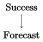

In [26]:
bn = readxdsl(Pkg.dir("BayesNets", "test", "sample_bn.xdsl"))